# Regulation is important for terminal state identification in pancreatic endocrine

Test the gene regulation roles in predicting terminal states

## Library imports

In [1]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import scvelo as scv

import cellrank as cr
import random

import seaborn as sns
import matplotlib.pyplot as plt
import mplscience

from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import (
    set_output,
)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "pancreatic_endocrine"

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [5]:
TERMINAL_STATES = ["Beta", "Alpha", "Delta", "Epsilon"]

In [6]:
N_STATES = 7

## Data loading

In [8]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed_filtered.h5ad")

## Model loading

In [9]:
vae = REGVELOVI.load(DATA_DIR / DATASET / "processed" / "rgv_model", adata)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/rgv_model/model.pt 
         already downloaded                                                                                        


## Delete regulation

In [10]:
adata_no_regulation = adata.copy()
vae.module.v_encoder.fc1.weight.data = vae.module.v_encoder.fc1.weight.data * 0
set_output(adata_no_regulation, vae, n_samples=30, batch_size=adata.n_obs)

In [11]:
scv.tl.velocity_graph(adata_no_regulation)

computing velocity graph (using 1/112 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


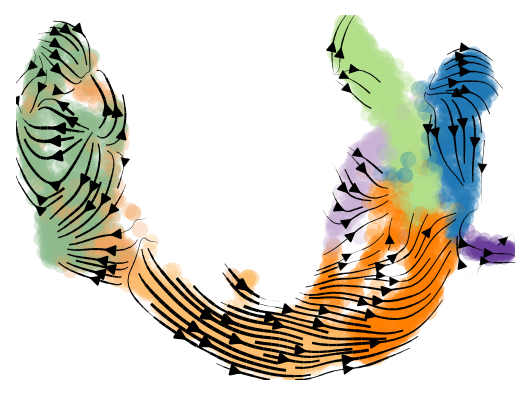

In [12]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    scv.pl.velocity_embedding_stream(adata_no_regulation, basis="umap", title="", legend_loc=False, ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / DATASET / "no_regulation_vector_field.svg", format="svg", transparent=True, bbox_inches="tight"
    )

### Predict terminal states

In [13]:
vk = cr.kernels.VelocityKernel(adata_no_regulation)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_no_regulation).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=N_STATES, cluster_key="clusters")

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

GPCCA[kernel=(0.8 * VelocityKernel[n=3696] + 0.2 * ConnectivityKernel[n=3696]), initial_states=None, terminal_states=None]

In [14]:
estimator.set_terminal_states(list(set(estimator.macrostates.cat.categories.tolist()).intersection(TERMINAL_STATES)))

GPCCA[kernel=(0.8 * VelocityKernel[n=3696] + 0.2 * ConnectivityKernel[n=3696]), initial_states=None, terminal_states=['Alpha', 'Beta', 'Delta']]

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


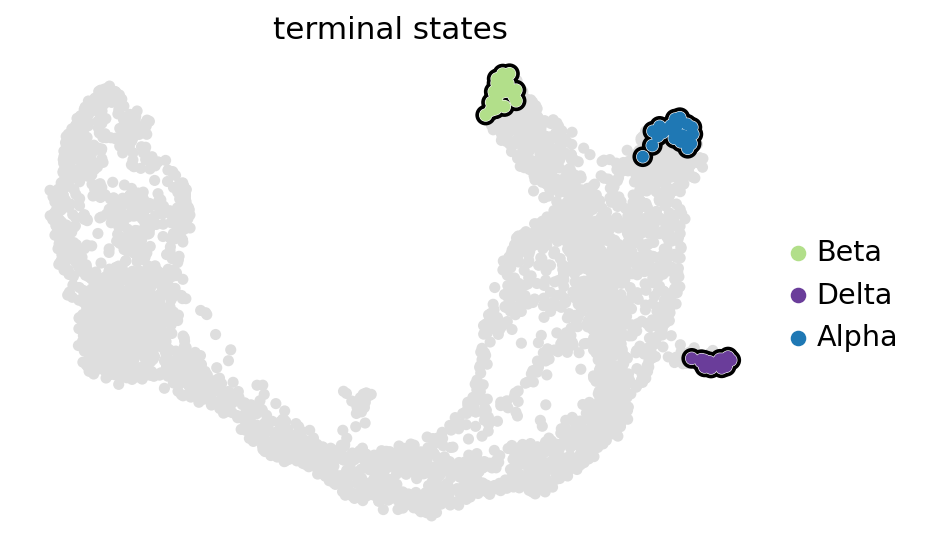

In [15]:
estimator.plot_macrostates(which="terminal", basis="umap", legend_loc="right", s=100)

## Randomize regulation

In [16]:
vae = REGVELOVI.load(DATA_DIR / DATASET / "processed" / "rgv_model", adata)
w = vae.module.v_encoder.fc1.weight.data.detach().clone().cpu().numpy()

# Shuffle genes to randomize weights
gene = adata.var.index.tolist()
random.shuffle(gene)
w = pd.DataFrame(w, index=gene, columns=gene)
w = w.loc[adata.var.index, adata.var.index]

# Convert back to tensor and move to GPU
w = torch.tensor(w.values, device="cuda:0")

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/rgv_model/model.pt 
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


In [17]:
vae.module.v_encoder.fc1.weight.data = w

In [18]:
adata_random_regulation = adata.copy()
set_output(adata_random_regulation, vae, n_samples=30, batch_size=adata.n_obs)

In [19]:
scv.tl.velocity_graph(adata_random_regulation)

computing velocity graph (using 1/112 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


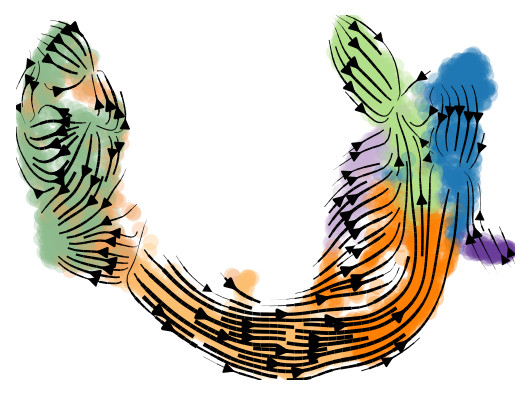

In [20]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    scv.pl.velocity_embedding_stream(adata_random_regulation, basis="umap", title="", legend_loc=False, ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / DATASET / "randomize_regulation_vector_field.svg", format="svg", transparent=True, bbox_inches="tight"
    )

### Predict terminal states

In [21]:
vk = cr.kernels.VelocityKernel(adata_random_regulation).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_random_regulation).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=N_STATES, cluster_key="clusters")

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

GPCCA[kernel=(0.8 * VelocityKernel[n=3696] + 0.2 * ConnectivityKernel[n=3696]), initial_states=None, terminal_states=None]

In [22]:
estimator.set_terminal_states(list(set(estimator.macrostates.cat.categories.tolist()).intersection(TERMINAL_STATES)))

GPCCA[kernel=(0.8 * VelocityKernel[n=3696] + 0.2 * ConnectivityKernel[n=3696]), initial_states=None, terminal_states=['Alpha', 'Beta']]

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


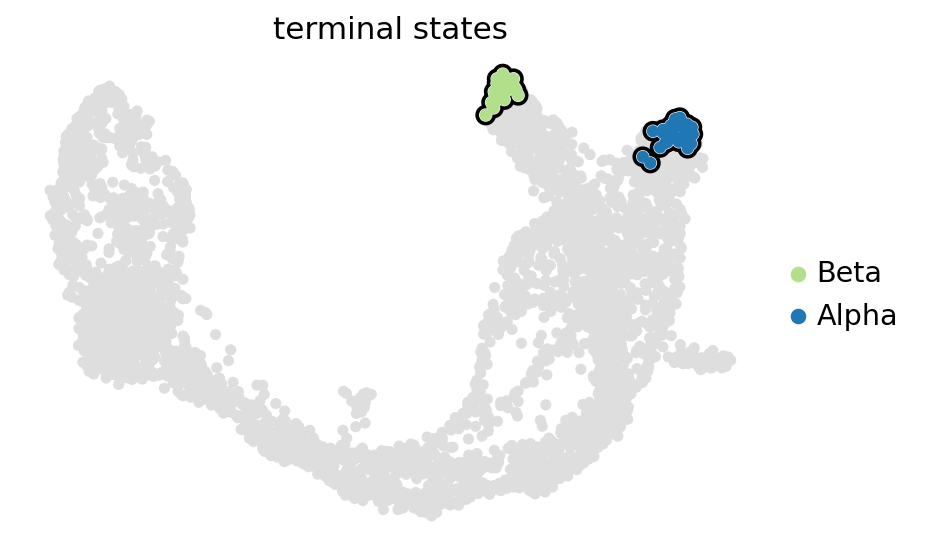

In [23]:
estimator.plot_macrostates(which="terminal", basis="umap", legend_loc="right", s=100)